## Using a pre-trained convnet

* 소규모 이미지 데이터 셋에 대해서 효과적인 딥러닝 방법은 사전 학습된 네트워크를 활용하는 것
* pre-trained model의 dataset 즉, original dataset이 충분히 크고, 일반화도 충분하다면 학습된 feature들이 새로운 문제에도 충분히 잘 대응할 수 있다. -> 이것은 딥러닝의 장점이다.
* the VGG16 architecture: a simple and widely used convnet architecture for ImageNet.
* pre-trained model을 활용하는 방법에는 2가지 : feature extraction & fine-tuning



In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader, Dataset,ConcatDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torchvision
import torchvision.models as models 
from torchsummary import summary
from torchvision.datasets import ImageFolder

import random 
import shutil 
import argparse 
from tqdm import tqdm
from PIL import Image



In [9]:
# torch 버전 확인
print(torch.__version__)
print(torchvision.__version__)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.1+cu117
0.12.0


'cuda'

## Download dataset

* dogs vs cats data set을 이용

In [12]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')


Downloading...
From (uriginal): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
From (redirected): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd&confirm=t&uuid=0c043dfb-6589-423a-9343-61f1f8d64250
To: /home/e1_u2/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:39<00:00, 21.5MB/s] 


In [32]:
import zipfile

# 압축하고자하는 파일의 경로
zip_file_path = 'dogs-vs-cats.zip'

# 원하는 경로
extract_to_path = 'data/datasets/dogs-vs-cats'

# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_to_path)

print(f'압축 파일을 {extract_to_path}에 성공적으로 풀었습니다.')

압축 파일을 data/datasets/dogs-vs-cats에 성공적으로 풀었습니다.


In [51]:
# 압축하고자하는 파일의 경로
zip_file_path = 'data/datasets/dogs-vs-cats/train.zip'

# 원하는 경로
extract_to_path = 'data/datasets/dogs-vs-cats/'

# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_to_path)

print(f'압축 파일을 {extract_to_path}에 성공적으로 풀었습니다.')

압축 파일을 data/datasets/dogs-vs-cats/에 성공적으로 풀었습니다.


In [57]:
# 압축하고자하는 파일의 경로
zip_file_path = 'data/datasets/dogs-vs-cats/test1.zip'

# 원하는 경로
extract_to_path = 'data/datasets/dogs-vs-cats/'

# ZIP 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_to_path)

print(f'압축 파일을 {extract_to_path}에 성공적으로 풀었습니다.')

압축 파일을 data/datasets/dogs-vs-cats/에 성공적으로 풀었습니다.


In [58]:
# 파일 이름 변경하기

directory_path = 'data/datasets/dogs-vs-cats/'
old_file_name = 'test1'
new_file_name = 'val'

# 파일 이름 변경
os.rename(os.path.join(directory_path, old_file_name), os.path.join(directory_path, new_file_name))

print(f"{old_file_name} 파일이 {new_file_name}으로 변경되었습니다.")

test1 파일이 val으로 변경되었습니다.


(1, 374, 500, 3)


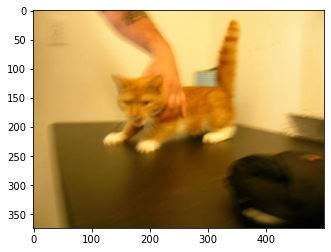

(1, 280, 300, 3)


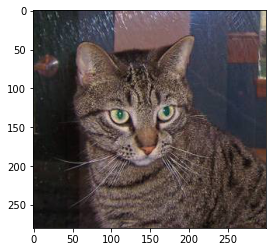

(1, 396, 312, 3)


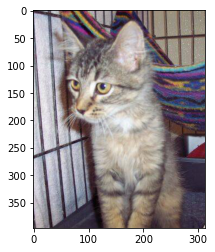

(1, 414, 500, 3)


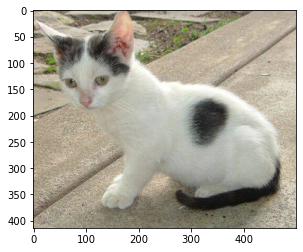

(1, 375, 499, 3)


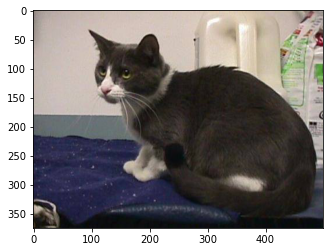

In [73]:
# 데이터 시각화 해보기
# 5개의 이미지를 불러와서 시각화 해보기

for i in range(5):

    img_path = f'data/datasets/dogs-vs-cats/train/cat.{i}.jpg'
    img = Image.open(img_path)

    img_tensor = np.array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    print(img_tensor.shape)
    plt.imshow(img_tensor[0])
    plt.show()

## Feature Extraction

* feature extraction(특징 추출) : pre-trained model에서 학습하여 얻은 representation을 이용하여 new sample에서 흥미로운 feature들을 추출하는 것
* 이 특징들을 scratch부터 학습한 새로운 classifier에 실행된다.
* Convnets은 2가지 파트로 구성: start part의 pooling & convolution layers, end part의 dense connected classifier 
* 앞부분을 "convolutional base" 라 한다.
* "feature extraction"은 pre-trained model의 convolutional base를 취하고(frozen), 그것을 통해 새로운 data를 실행하고, 새로운 classifier를 학습시킨다. 
* 왜 convolutional base 만 재사용할까? : 이 부분에서 학습한 representation들이 일반성을 띄고 있기 때문. 반면에 classifier 에서의 representation들은 class 집합에 한정하며, 전체 그림에서 어느 클래스에 존재할 지에 대한 확률 정보만 포함한다. dense layer에서는 더 이상 이미지 객체가 어디에 있는지에 대한 정보가 없다.   
* 특정 컨볼루션 레이어가 추출한 표현의 일반성(따라서 재사용 가능성) 수준은 모델의 레이어 깊이에 따라 달라진다. 
* 모델의 앞쪽에 있는 레이어는 시각적 가장자리, 색상, 텍스처와 같은 국소적이고 매우 일반적인 특징 맵을 추출하는 반면, 더 위쪽의 레이어는 '고양이 귀' 또는 '개 눈'과 같은 보다 추상적인 개념을 추출한다. 


![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

## Pre-trained model 가져오기: the VGG16 model


In [21]:
vgg16 = models.vgg16(pretrained=True).cuda()
# If "pretrained" is True, returns a model pre-trained on ImageNet

output = vgg16(torch.zeros(8, 3, 150, 150).cuda())
print(output.shape)

# Modify last layer in classifier to use the model for binary classification
num_classes = 2
vgg16.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=num_classes, bias=True)

vgg16.cuda()
output = vgg16(torch.zeros(8, 3, 150, 150).cuda())
print(output.shape)

vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/e1_u2/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:30<00:00, 18.2MB/s] 


torch.Size([8, 1000])
torch.Size([8, 2])


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
summary(vgg16, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [23]:
# 학습된 feature들을 추출해보기

feature_extractor = vgg16.features
input_tensor = torch.zeros((8, 3, 150, 150)).cuda()
features = feature_extractor(input_tensor) 
print(features.shape)

torch.Size([8, 512, 4, 4])


In [59]:
class CustomDataset(Dataset):
    def __init__(self, phase):
        self.phase = phase 
        # self.data_root = 'data/datasets/dogs-vs-cats'
        self.data_root = os.path.abspath('data/datasets/dogs-vs-cats') # 절대 경로로 변경
        self.data_path = os.path.join(self.data_root, self.phase)
        self.data_list = os.listdir(self.data_path)
    
        self.train_trans = transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),]) 
        self.val_trans = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),])
        
        
        
    def __len__(self):
        return len(self.data_list)
    
    
    def __getitem__(self, idx):
        filename = os.path.join(self.data_path, self.data_list[idx])
        img = Image.open(filename)
        if self.phase == 'train':
            img = self.train_trans(img) 
        else:
            img = self.val_trans(img) 
            
        if 'cat' in self.data_list[idx]:
            label = 0
        else:
            label = 1
        
        return img, label

## Train & Eval function

In [60]:
class Trainer(object):
    def __init__(self, batch_size, lr, checkname, pretrained):
        self.batch_size = batch_size
        self.lr = lr
        self.checkname = checkname
        self.pretrained = pretrained
        
        self.train_dataset = CustomDataset('train') 
        self.train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
        self.val_dataset = CustomDataset('val')
        self.val_dataloader = torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
        self.device = 'cuda'
        
        self.model = models.vgg16(pretrained=pretrained)
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        self.model = self.model.to(self.device)
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr) 
        self.criterion = nn.CrossEntropyLoss()
        self.save_root = os.path.join('saved_model/dogs-vs-cats', self.checkname)
        os.makedirs(self.save_root, exist_ok=True)
        self.best_pred = 0
        self.train_acc_list = []
        self.train_loss_list = []
        self.val_acc_list = []
        self.val_loss_list = []
        
    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        total = 0
        for i, (img, label) in tqdm(enumerate(self.train_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            pred = self.model(img) 
            _, predicted = torch.max(pred.data, 1) 
            self.train_acc += (predicted==label).sum().item() 
            total += label.size(0)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
        self.train_acc_list.append(self.train_acc/total)
        self.train_loss_list.append(self.total_loss/(i+1))
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        print('Training Accuracy : %.5f'%(self.train_acc/total))
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (img, label) in tqdm(enumerate(self.val_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            with torch.no_grad():
                pred = self.model(img) 
                _, predicted = torch.max(pred.data,1) 
                
                self.val_acc += (predicted==label).sum().item() 
                total += label.size(0) 
                loss = self.criterion(pred, label) 
                self.val_loss += loss
                
        self.val_acc_list.append(self.val_acc/total) 
        self.val_loss_list.append(self.val_loss/(i+1))
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation accuracy : %.5f'%(self.val_acc/total))
              
        if self.val_acc/total > self.best_pred:
            self.best_pred = self.val_acc/total
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))

In [61]:
# train을 간편하게 하는 함수 정의

def fit(epochs, batch_size, lr, checkname, pretrained):
    trainer = Trainer(batch_size, lr, checkname, pretrained)
    for epoch in range(epochs):
        print('Epoch :', str(epoch))
        trainer.training(epoch) 
        trainer.validation(epoch)
        print("========================================")
    print('Best prediction on Validation set :', trainer.best_pred)
    return trainer

In [62]:
trainer = fit(5, 32, 2e-5, 'exp1', 0) # epoch, batch_size, lr, checkname, pretrained  
# It takes few minutes to train the model.

Epoch : 0


782it [03:34,  3.65it/s]


Training loss : 0.63031
Training Accuracy : 0.62724


391it [01:31,  4.29it/s]


Validation loss : 0.89344
Validation accuracy : 0.47632
Epoch : 1


782it [03:33,  3.66it/s]


Training loss : 0.51017
Training Accuracy : 0.74952


391it [01:31,  4.29it/s]


Validation loss : 1.26656
Validation accuracy : 0.51432
Epoch : 2


782it [03:33,  3.66it/s]


Training loss : 0.43008
Training Accuracy : 0.80336


391it [01:32,  4.23it/s]


Validation loss : 0.70772
Validation accuracy : 0.65696
Epoch : 3


782it [03:33,  3.66it/s]


Training loss : 0.36190
Training Accuracy : 0.84068


391it [01:30,  4.34it/s]


Validation loss : 2.03059
Validation accuracy : 0.28576
Epoch : 4


782it [03:33,  3.66it/s]


Training loss : 0.30557
Training Accuracy : 0.86680


391it [01:29,  4.36it/s]

Validation loss : 2.43303
Validation accuracy : 0.46472
Best prediction on Validation set : 0.65696


## Visualization

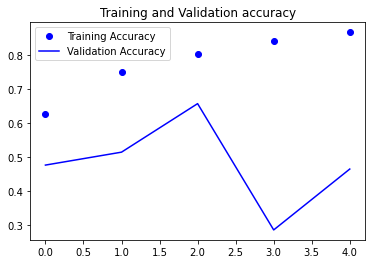

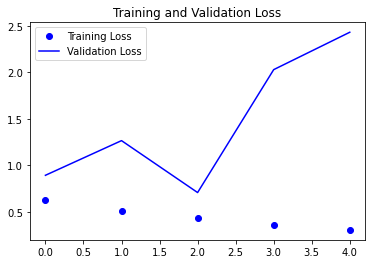

In [63]:
import matplotlib.pyplot as plt 

train_acc = trainer.train_acc_list
val_acc = trainer.val_acc_list 

train_loss = trainer.train_loss_list 
val_loss = trainer.val_loss_list 

train_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in train_loss]
val_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in val_loss]

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title("Training and Validation accuracy")
plt.legend() 
plt.figure() 

plt.plot(epochs, train_loss_np_list, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_np_list, 'b', label='Validation Loss') 
plt.title("Training and Validation Loss")
plt.legend() 
plt.show()

## Fine-tuning

* Fine-tuning은 미리 훈련된(pre-trained) 신경망 모델을 가져와서 이 모델을 특정 작업에 맞게 조정하는 기술
* layer 몇개를 unfreezing 하여 new task에 더 맞게 조정해나가는 방법



![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)


## The steps for fine-tuning

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. 
Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [74]:
class Trainer(object):
    def __init__(self, batch_size, lr, checkname, pretrained):
        self.batch_size = batch_size
        self.lr = lr
        self.checkname = checkname
        self.pretrained = pretrained
        
        self.train_dataset = CustomDataset('train') 
        self.train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
        self.val_dataset = CustomDataset('val')
        self.val_dataloader = torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
        self.device = 'cuda'
        self.model = models.vgg16(pretrained=pretrained)
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        update_params_names = ['features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias','features.28.weight','features.28.bias']
        for name, param in self.model.named_parameters():
            if 'classifier' not in name and name not in update_params_names:
                param.requires_grad = False 
            else:
                param.requires_grad = True

        self.model = self.model.to(self.device)
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr) 
        self.criterion = nn.CrossEntropyLoss()
        self.save_root = os.path.join('saved_model/dogs-vs-cats/ckpts', self.checkname)
        os.makedirs(self.save_root, exist_ok=True)
        self.best_pred = 0
        self.train_acc_list = []
        self.train_loss_list = []
        self.val_acc_list = []
        self.val_loss_list = []
        
    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        total = 0
        for i, (img, label) in tqdm(enumerate(self.train_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            pred = self.model(img) 
            _, predicted = torch.max(pred.data, 1) 
            self.train_acc += (predicted==label).sum().item() 
            total += label.size(0)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
        self.train_acc_list.append(self.train_acc/total)
        self.train_loss_list.append(self.total_loss/(i+1))
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        print('Training Accuracy : %.5f'%(self.train_acc/total))
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (img, label) in tqdm(enumerate(self.val_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            with torch.no_grad():
                pred = self.model(img) 
                _, predicted = torch.max(pred.data,1) 
                
                self.val_acc += (predicted==label).sum().item() 
                total += label.size(0) 
                loss = self.criterion(pred, label) 
                self.val_loss += loss
                
        self.val_acc_list.append(self.val_acc/total) 
        self.val_loss_list.append(self.val_loss/(i+1))
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation accuracy : %.5f'%(self.val_acc/total))
              
        if self.val_acc/total > self.best_pred:
            self.best_pred = self.val_acc/total
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))


In [76]:
# train the model
trainer = fit(5, 32, 2e-5, 'exp1', 0)

Epoch : 0


782it [03:08,  4.16it/s]


Training loss : 0.64886
Training Accuracy : 0.61064


391it [01:30,  4.32it/s]


Validation loss : 0.79128
Validation accuracy : 0.50352
Epoch : 1


782it [03:09,  4.13it/s]


Training loss : 0.56721
Training Accuracy : 0.70400


391it [01:29,  4.37it/s]


Validation loss : 0.80436
Validation accuracy : 0.51552
Epoch : 2


782it [03:09,  4.13it/s]


Training loss : 0.51983
Training Accuracy : 0.74372


391it [01:30,  4.34it/s]


Validation loss : 1.19896
Validation accuracy : 0.35856
Epoch : 3


782it [03:09,  4.12it/s]


Training loss : 0.49161
Training Accuracy : 0.75992


391it [01:30,  4.30it/s]


Validation loss : 1.79035
Validation accuracy : 0.22560
Epoch : 4


782it [03:10,  4.10it/s]


Training loss : 0.46908
Training Accuracy : 0.77636


391it [01:30,  4.31it/s]


Validation loss : 0.69672
Validation accuracy : 0.65864
Best prediction on Validation set : 0.65864


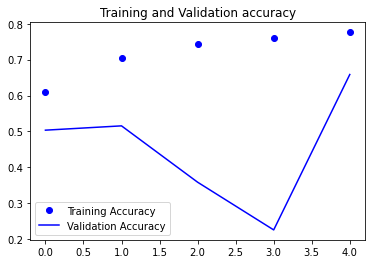

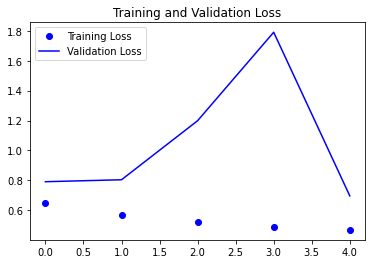

In [77]:
# 결과 시각화 하기

train_acc = trainer.train_acc_list
val_acc = trainer.val_acc_list 

train_loss = trainer.train_loss_list 
val_loss = trainer.val_loss_list

train_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in train_loss]
val_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in val_loss]

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title("Training and Validation accuracy")
plt.legend() 
plt.figure() 

plt.plot(epochs, train_loss_np_list, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_np_list, 'b', label='Validation Loss') 
plt.title("Training and Validation Loss")
plt.legend() 
plt.show()


## Additional Experiment 
* accuracy가 낮아서 epoch를 늘려서 학습을 시켜보기 
* minimum에 빠르게 도달하기 위해 optimizer를 Adam으로 변경
* 부족할 경우, 추가적으로 lr 수정


In [78]:
class Trainer(object):
    def __init__(self, batch_size, lr, checkname, pretrained):
        self.batch_size = batch_size
        self.lr = lr
        self.checkname = checkname
        self.pretrained = pretrained
        
        self.train_dataset = CustomDataset('train') 
        self.train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
        self.val_dataset = CustomDataset('val')
        self.val_dataloader = torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
        self.device = 'cuda'
        self.model = models.vgg16(pretrained=pretrained)
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        update_params_names = ['features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias','features.28.weight','features.28.bias']
        
        for name, param in self.model.named_parameters():
            if 'classifier' not in name and name not in update_params_names:
                param.requires_grad = False 
            else:
                param.requires_grad = True

        self.model = self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr) 
        self.criterion = nn.CrossEntropyLoss()
        self.save_root = os.path.join('saved_model/dogs-vs-cats/ckpts', self.checkname)
        os.makedirs(self.save_root, exist_ok=True)
        self.best_pred = 0
        self.train_acc_list = []
        self.train_loss_list = []
        self.val_acc_list = []
        self.val_loss_list = []
        
    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        total = 0
        for i, (img, label) in tqdm(enumerate(self.train_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            pred = self.model(img) 
            _, predicted = torch.max(pred.data, 1) 
            self.train_acc += (predicted==label).sum().item() 
            total += label.size(0)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
        self.train_acc_list.append(self.train_acc/total)
        self.train_loss_list.append(self.total_loss/(i+1))
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        print('Training Accuracy : %.5f'%(self.train_acc/total))
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (img, label) in tqdm(enumerate(self.val_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            with torch.no_grad():
                pred = self.model(img) 
                _, predicted = torch.max(pred.data,1) 
                
                self.val_acc += (predicted==label).sum().item() 
                total += label.size(0) 
                loss = self.criterion(pred, label) 
                self.val_loss += loss
                
        self.val_acc_list.append(self.val_acc/total) 
        self.val_loss_list.append(self.val_loss/(i+1))
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation accuracy : %.5f'%(self.val_acc/total))
              
        if self.val_acc/total > self.best_pred:
            self.best_pred = self.val_acc/total
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))


In [80]:
# train the model
trainer = fit(10, 32, 2e-5, 'exp1', 0) # epoch을 10으로 늘려서 학습을 진행해보기

Epoch : 0


782it [03:11,  4.09it/s]


Training loss : 0.65526
Training Accuracy : 0.59816


391it [01:30,  4.30it/s]


Validation loss : 0.94009
Validation accuracy : 0.40752
Epoch : 1


782it [03:11,  4.09it/s]


Training loss : 0.58204
Training Accuracy : 0.69240


391it [01:30,  4.31it/s]


Validation loss : 0.91580
Validation accuracy : 0.45704
Epoch : 2


782it [03:13,  4.04it/s]


Training loss : 0.53448
Training Accuracy : 0.73048


391it [01:30,  4.30it/s]


Validation loss : 1.04084
Validation accuracy : 0.44320
Epoch : 3


782it [03:10,  4.10it/s]


Training loss : 0.49774
Training Accuracy : 0.75708


391it [01:30,  4.31it/s]


Validation loss : 1.26344
Validation accuracy : 0.40320
Epoch : 4


782it [03:10,  4.11it/s]


Training loss : 0.47272
Training Accuracy : 0.77172


391it [01:30,  4.34it/s]


Validation loss : 0.86805
Validation accuracy : 0.59432
Epoch : 5


782it [03:11,  4.09it/s]


Training loss : 0.45243
Training Accuracy : 0.78452


391it [01:30,  4.32it/s]


Validation loss : 1.15447
Validation accuracy : 0.50728
Epoch : 6


782it [03:09,  4.12it/s]


Training loss : 0.43979
Training Accuracy : 0.79376


391it [01:30,  4.33it/s]


Validation loss : 0.89741
Validation accuracy : 0.58024
Epoch : 7


782it [03:09,  4.13it/s]


Training loss : 0.42045
Training Accuracy : 0.80468


391it [01:30,  4.33it/s]


Validation loss : 0.96478
Validation accuracy : 0.56840
Epoch : 8


782it [03:09,  4.12it/s]


Training loss : 0.40962
Training Accuracy : 0.81204


391it [01:29,  4.35it/s]


Validation loss : 1.16039
Validation accuracy : 0.50464
Epoch : 9


782it [03:09,  4.12it/s]


Training loss : 0.39308
Training Accuracy : 0.81872


391it [01:29,  4.35it/s]

Validation loss : 1.47836
Validation accuracy : 0.46296
Best prediction on Validation set : 0.59432


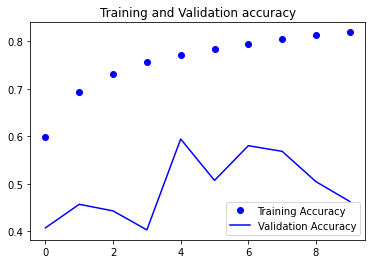

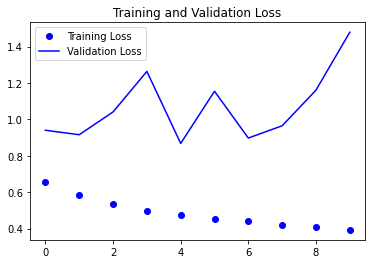

In [81]:
# 결과 시각화 하기

train_acc = trainer.train_acc_list
val_acc = trainer.val_acc_list 

train_loss = trainer.train_loss_list 
val_loss = trainer.val_loss_list

train_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in train_loss]
val_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in val_loss]

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title("Training and Validation accuracy")
plt.legend() 
plt.figure() 

plt.plot(epochs, train_loss_np_list, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_np_list, 'b', label='Validation Loss') 
plt.title("Training and Validation Loss")
plt.legend() 
plt.show()


# Inference on Test dataset (Visualize)

In [86]:
class Inferer():
    def __init__(self, exp):
        self.model = models.vgg16()
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        self.test_root = 'data/datasets/dogs-vs-cats/val'
        self.saved_model_path = 'saved_model/dogs-vs-cats'
        self.ckpt = torch.load(os.path.join(self.saved_model_path, exp, 'model_best.pth'))
        self.model.load_state_dict(self.ckpt) 
        self.model = self.model.to('cuda') 
    
        self.test_list = os.listdir('data/datasets/dogs-vs-cats/val')
        random.shuffle(self.test_list)
        self.img_trans = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),])
        self.label_dict = {0:'cat', 1:'dog'}
        self.model.eval()
    
    def infer(self): 
        for item in self.test_list[:10]:
            tgt = os.path.join(self.test_root, item)
            PIL_img = Image.open(tgt)
            img = self.img_trans(PIL_img)
            img = img.unsqueeze(0).cuda()
            output = self.model(img) 
            _, predicted = torch.max(output,1)
            plt.axis("off")
            plt.imshow(PIL_img) 
            print('Prediction :', self.label_dict[predicted.item()])
            plt.show()

Prediction : cat


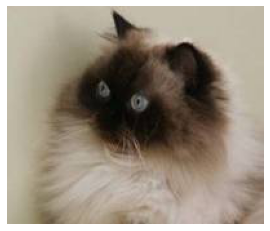

Prediction : dog


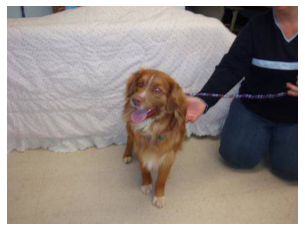

Prediction : cat


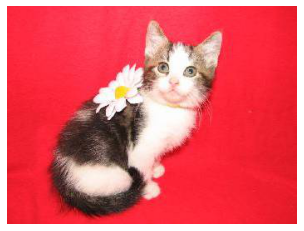

Prediction : cat


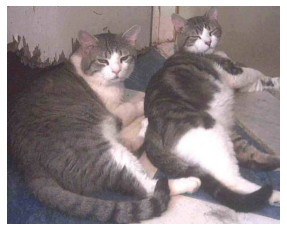

Prediction : cat


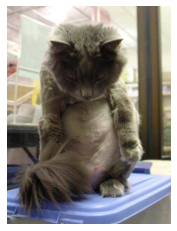

Prediction : dog


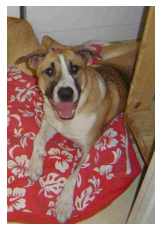

Prediction : dog


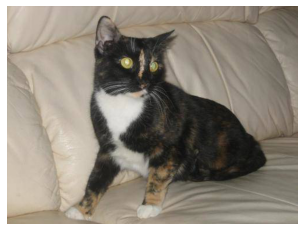

Prediction : cat


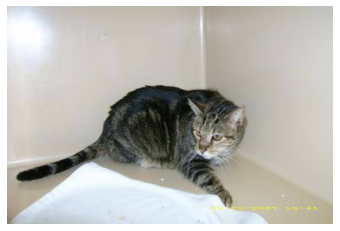

Prediction : dog


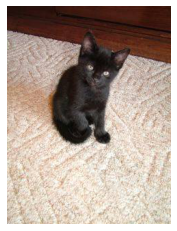

Prediction : dog


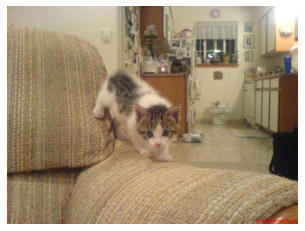

In [87]:
infer_exp1 = Inferer('exp1')
infer_exp1.infer()